## Pairs Trading Crypto Notebook

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from tqdm.notebook import tqdm

%matplotlib inline

### Loading data

In [2]:
daily_data_path = "../data/aggregate/output1d.csv"
# hourly_data_path = '../data/aggregate/output1h.csv'

try:
    df = pd.read_csv(daily_data_path)
    print(f"DataFrame loaded successfully from {daily_data_path}")
except FileNotFoundError:
    print(f"Error: The file {daily_data_path} does not exist.")
except pd.errors.EmptyDataError:
    print(f"Error: The file {daily_data_path} is empty.")
except pd.errors.ParserError:
    print(f"Error: Could not parse the file {daily_data_path}.")

DataFrame loaded successfully from ../data/aggregate/output1d.csv


### Very Basic EDA

In [3]:
df.head()

,Pair,ClosePrice,CloseTime,QuoteAssetVolume
0,OPUSDT,0.530,1656719999999,9.651888e+06
1,OPUSDT,0.525,1656806399999,6.379138e+06
2,OPUSDT,0.522,1656892799999,3.775525e+06
3,OPUSDT,0.560,1656979199999,7.673065e+06
4,OPUSDT,0.524,1657065599999,9.287853e+06


In [4]:
df["CloseTime"] = pd.to_datetime(df["CloseTime"], unit="ms")

In [5]:
print(df.dtypes)
print("Shape", df.shape)

Pair                        object
ClosePrice                 float64
CloseTime           datetime64[ns]
QuoteAssetVolume           float64
dtype: object
Shape (88533, 4)


There are 81 pairs!
count      81.000000
mean     1093.000000
std       621.445915
min        15.000000
25%       470.000000
50%      1279.000000
75%      1735.000000
max      1735.000000
Name: Pair, dtype: float64


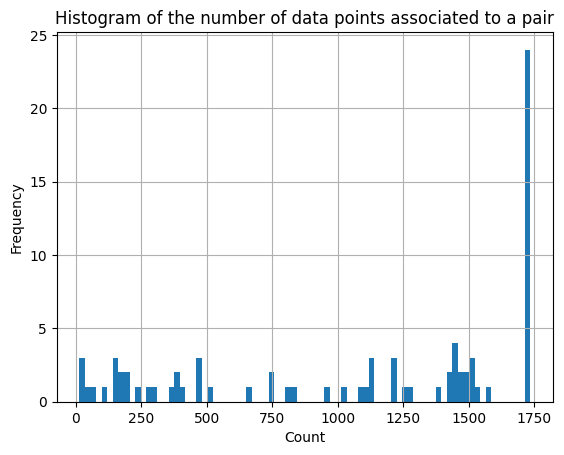

In [6]:
print(f"There are {len(df['Pair'].unique())} pairs!")
print(df["Pair"].value_counts().describe())

df["Pair"].value_counts().hist(bins=81)
plt.title("Histogram of the number of data points associated to a pair")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()

In [7]:
def plot_price_and_vol(df):
    _, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

    # Plotting the Close Price
    axs[0].plot(df["CloseTime"], df["ClosePrice"], color="blue", linewidth=1)
    axs[0].set_title(df["Pair"].iloc[0] + " Daily Close Price")
    axs[0].set_xlabel("Time")
    axs[0].set_ylabel("Close Price (USDT)")
    axs[0].grid(True)

    # Plotting the Volume
    axs[1].bar(df["CloseTime"], df["QuoteAssetVolume"], color="orange", width=0.5)
    axs[1].set_title(df["Pair"].iloc[0] + " Daily Volume")
    axs[1].set_xlabel("Time")
    axs[1].set_ylabel("Volume (USDT)")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

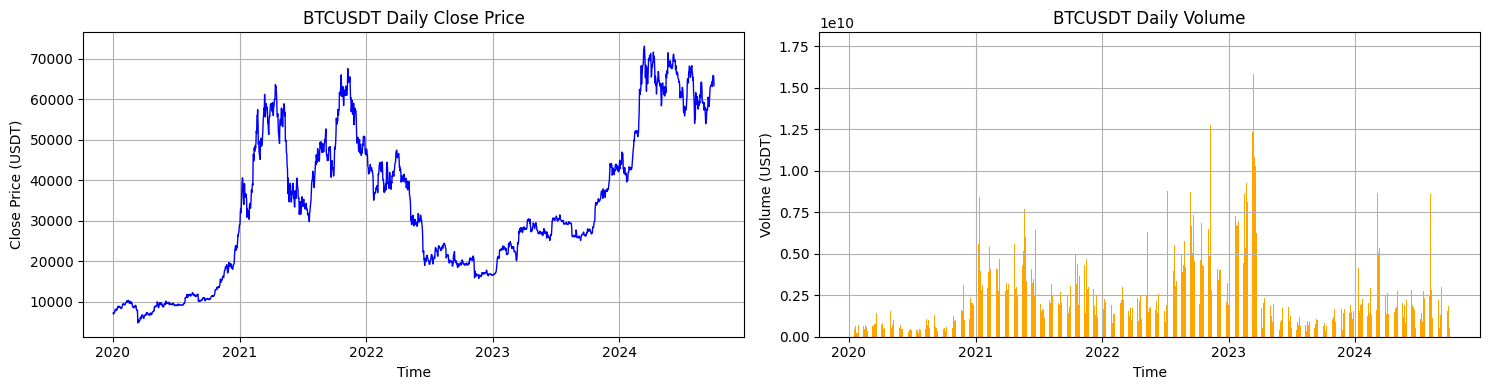

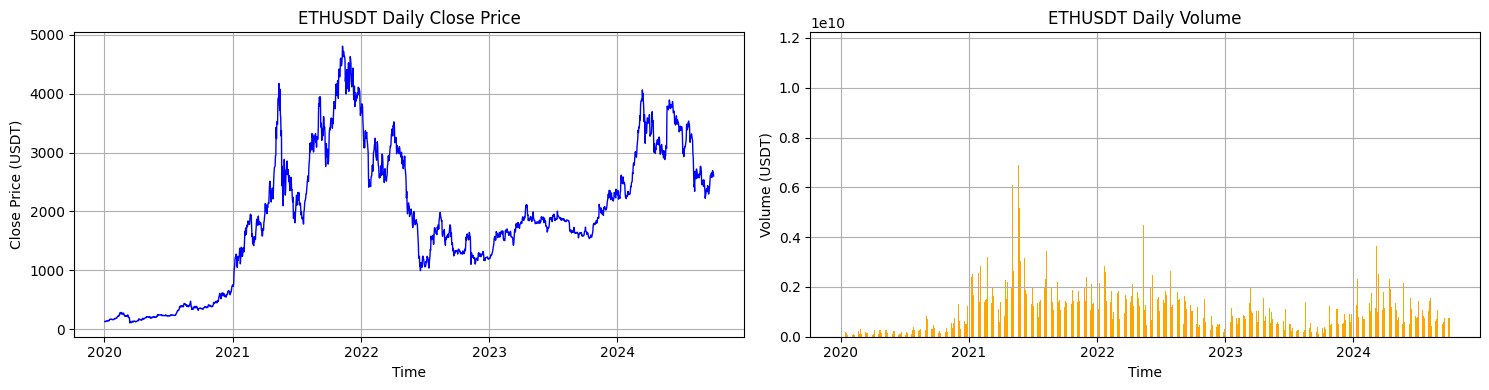

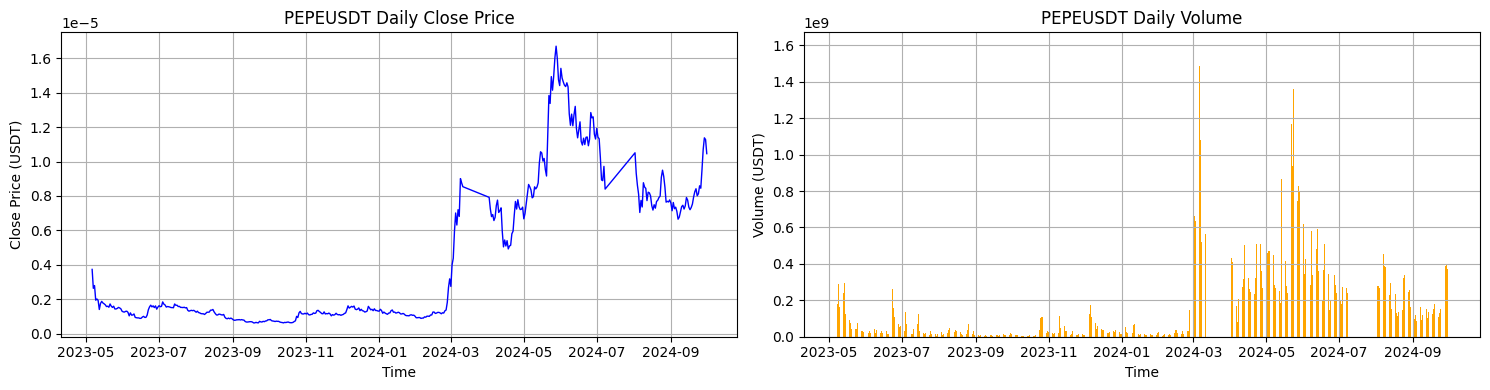

In [8]:
pepe_df = df[df["Pair"] == "PEPEUSDT"]
pepe_df = pepe_df.sort_values(by="CloseTime")
btc_df = df[df["Pair"] == "BTCUSDT"]
btc_df = btc_df.sort_values(by="CloseTime")
eth_df = df[df["Pair"] == "ETHUSDT"]
eth_df = eth_df.sort_values(by="CloseTime")
plot_price_and_vol(btc_df)
plot_price_and_vol(eth_df)
plot_price_and_vol(pepe_df)

##### Looking at dates

In [9]:
time = df.copy()
time["isEOD"] = df["CloseTime"].dt.time == pd.Timestamp("23:59:59.999").time()
time["isEOD"].value_counts()

True     88525
False        8
Name: isEOD, dtype: int64

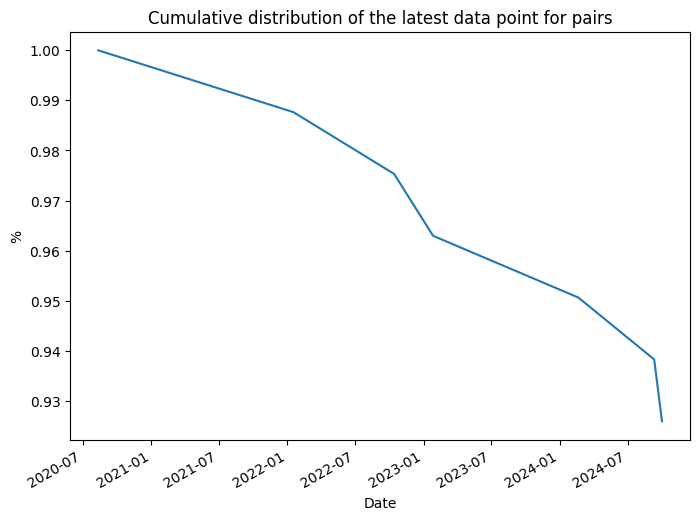

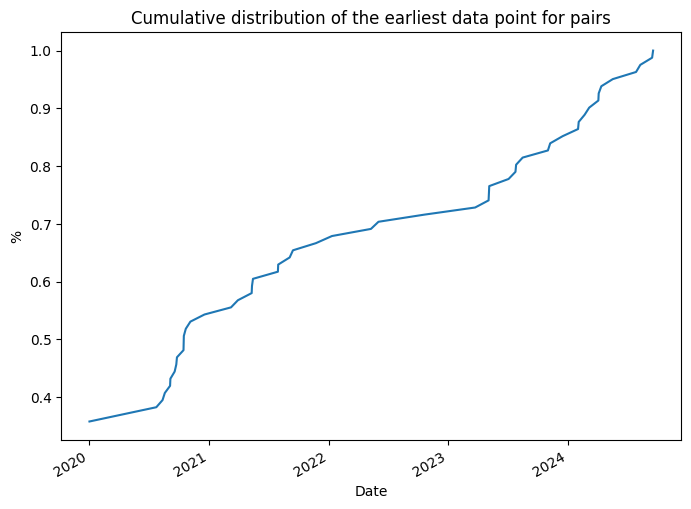

2024-09-30 23:59:59.999    0.925926
2024-09-10 02:59:59.999    0.938272
2024-02-20 02:59:59.999    0.950617
2023-01-26 08:59:59.999    0.962963
2022-10-14 02:59:59.999    0.975309
2022-01-17 03:59:59.999    0.987654
2020-08-12 03:59:59.999    1.000000
Name: LatestDate, dtype: float64
2024-05-16 23:59:59.999    0.950617
2024-07-26 23:59:59.999    0.962963
2024-08-08 23:59:59.999    0.975309
2024-09-13 23:59:59.999    0.987654
2024-09-16 23:59:59.999    1.000000
Name: EarliestDate, dtype: float64


In [10]:
earliest_latest_date_helper = (
    df.groupby("Pair")
    .agg(EarliestDate=("CloseTime", "min"), LatestDate=("CloseTime", "max"))
    .reset_index()
)

latest_date_helper = (
    earliest_latest_date_helper["LatestDate"]
    .value_counts()
    .sort_index(ascending=False)
    .cumsum()
    / earliest_latest_date_helper.shape[0]
)
plt.figure(figsize=(8, 6))
latest_date_helper.plot()
plt.title("Cumulative distribution of the latest data point for pairs")
plt.xlabel("Date")
plt.ylabel("%")
plt.show()


earliest_date_helper = (
    earliest_latest_date_helper["EarliestDate"]
    .value_counts()
    .sort_index(ascending=True)
    .cumsum()
    / earliest_latest_date_helper.shape[0]
)
plt.figure(figsize=(8, 6))
earliest_date_helper.plot()
plt.title("Cumulative distribution of the earliest data point for pairs")
plt.xlabel("Date")
plt.ylabel("%")
plt.show()

print(latest_date_helper)
print(earliest_date_helper.tail())

### Util Functions

In [11]:
def do_and_report(func, df):
    old_row_count = df.shape[0]
    old_pair_count = len(df["Pair"].unique())
    new_df = func(df)
    new_row_count = new_df.shape[0]
    new_pair_count = len(new_df["Pair"].unique())
    print(
        f"Pairs Dropped {old_pair_count - new_pair_count} from {old_pair_count} ({100 * (old_pair_count - new_pair_count)/old_pair_count:.2f}%)"
    )
    print(
        f"Rows Dropped {old_row_count - new_row_count} from {old_row_count} ({100 * (old_row_count - new_row_count)/old_row_count:.2f}%)"
    )
    return new_df

### Data Cleaning
- There's some missing data in PEPEUSDT and probably other pairs. Fill by interpolation.
- Looking at the cumulative distribution graphs, it looks like most pairs have a latest data point at 2024-09-30 and around 70% have earliest data <= Jan 2022 so we drop pairs that do not meet this criteria

##### Remove pairs without enough data

In [12]:
def drop_pairs_without_enough_data(df, earliest="2022-01-01", latest="2024-09-30"):
    latest_bound = pd.to_datetime(latest)
    earliest_bound = pd.to_datetime(earliest)

    pair_helper = (
        df.groupby("Pair")["CloseTime"]
        .agg(min=lambda x: x.min(), max=lambda x: x.max())
        .reset_index()
    )
    invalid_pairs = pair_helper[
        (pair_helper["min"] > earliest_bound) | (pair_helper["max"] < latest_bound)
    ]["Pair"]
    return df[~df["Pair"].isin(invalid_pairs)]

In [13]:
df = do_and_report(drop_pairs_without_enough_data, df)

Pairs Dropped 33 from 81 (40.74%)
Rows Dropped 14908 from 88533 (16.84%)


In [14]:
time = df.copy()
time["isEOD"] = df["CloseTime"].dt.time == pd.Timestamp("23:59:59.999").time()
time["isEOD"].value_counts()

True     73623
False        2
Name: isEOD, dtype: int64

##### Missing data

In [15]:
pepe_df["TimeDiff"] = pepe_df["CloseTime"].diff()
pepe_df["TimeDiff"].value_counts()

1 days     467
22 days      1
25 days      1
Name: TimeDiff, dtype: int64

In [16]:
def print_missing_days(df):
    missing_date_helper = (
        df.groupby("Pair")
        .agg(
            MissingDates=(
                "CloseTime",
                lambda x: 100 * ((x.max() - x.min()).days + 1 - x.count()) / x.count(),
            ),  # Calculate # of missing dates
        )
        .reset_index()
    )

    print(
        missing_date_helper["MissingDates"].value_counts().sort_index(ascending=False)
    )

In [17]:
print_missing_days(df)

21.754386     1
10.509554     1
2.352941      1
2.201835      1
2.181818      1
2.114537      1
2.112676      1
1.980198      1
1.975309      1
1.973684      1
1.907790      1
1.876466      1
0.000000     36
Name: MissingDates, dtype: int64


Drop pairs where the missing value is > 3% and interpolate Price and Volume for the rest

In [18]:
def drop_pairs_with_missing_values(df, threshold=3):
    missing_helper = (
        df.groupby("Pair")
        .agg(
            MissingDates=(
                "CloseTime",
                lambda x: 100 * ((x.max() - x.min()).days + 1 - x.count()) / x.count(),
            )
        )
        .reset_index()
    )
    pairs_to_drop = missing_helper[missing_helper["MissingDates"] > threshold]["Pair"]
    return df[~df["Pair"].isin(pairs_to_drop)]

In [19]:
df = do_and_report(drop_pairs_with_missing_values, df)

Pairs Dropped 2 from 48 (4.17%)
Rows Dropped 2995 from 73625 (4.07%)


In [20]:
def interpolate_missing_data(group):
    group = group.set_index("CloseTime")
    full_time_range = pd.date_range(
        start=group.index.min(), end=group.index.max(), freq="1D"
    )
    group = group.reindex(full_time_range)

    group["ClosePrice"] = group["ClosePrice"].interpolate(method="linear")
    group["QuoteAssetVolume"] = group["QuoteAssetVolume"].interpolate(method="linear")

    group["Pair"] = group["Pair"].fillna(method="ffill")
    group = group.reset_index().rename(columns={"index": "CloseTime"})

    return group

In [21]:
df = df.groupby("Pair").apply(interpolate_missing_data).reset_index(drop=True)

In [22]:
print_missing_days(df)

0.0    46
Name: MissingDates, dtype: int64


In [23]:
time = df.copy()
time["isEOD"] = df["CloseTime"].dt.time == pd.Timestamp("23:59:59.999").time()
time["isEOD"].value_counts()

True    70870
Name: isEOD, dtype: int64

### Finding Pairs

Plan is to do OLS, then ADF and look for significant values (and check that it looks reasonable...)

In [24]:
def get_adf_stat(model):
    residuals = model.resid
    return adfuller(residuals)[0]


sorted_df_cache = dict()


def get_sorted_df(df, pair):
    if pair not in sorted_df_cache:
        # Filter and sort the DataFrame for the given pair
        sorted_df_cache[pair] = df[df["Pair"] == pair].sort_values(by="CloseTime")
    return sorted_df_cache[pair]


def engle_granger_test(
    df, pair1, pair2, start_date="2022-07-01", end_date="2024-01-01", hide_plot=True
):
    df_1 = get_sorted_df(df, pair1)[["CloseTime", "ClosePrice"]]
    df_2 = get_sorted_df(df, pair2)[["CloseTime", "ClosePrice"]]

    # start_date = max(df_1["CloseTime"].min(), df_2["CloseTime"].min())

    X = df_1[
        (df_1["CloseTime"] >= start_date) & (df_1["CloseTime"] < end_date)
    ].reset_index(drop=True)["ClosePrice"]
    y = df_2[
        (df_2["CloseTime"] >= start_date) & (df_2["CloseTime"] < end_date)
    ].reset_index(drop=True)["ClosePrice"]
    # log_X = np.log(X)
    # log_y = np.log(y)

    X_with_constant = sm.add_constant(X)
    y_with_constant = sm.add_constant(y)
    # log_X_with_constant = sm.add_constant(log_X)
    # log_y_with_constant = sm.add_constant(log_y)

    # print(df_1_train.shape)
    # print(df_2_train.shape)
    models = []
    models.append(sm.OLS(y, X).fit())
    models.append(sm.OLS(y, X_with_constant).fit())
    # models.append(sm.OLS(log_y, log_X).fit())
    # models.append(sm.OLS(log_y, log_X_with_constant).fit())
    models.append(sm.OLS(X, y).fit())
    models.append(sm.OLS(X, y_with_constant).fit())
    # models.append(sm.OLS(log_X, log_y).fit())
    # models.append(sm.OLS(log_X, log_y_with_constant).fit())

    lowest_score = float("inf")
    method = -1
    for i, model in enumerate(models):
        score = get_adf_stat(model)
        if score < lowest_score:
            lowest_score = score
            method = i

    if hide_plot:
        return lowest_score, method

    dates = df_1[
        (df_1["CloseTime"] >= start_date) & (df_1["CloseTime"] < end_date)
    ].reset_index(drop=True)["CloseTime"]
    plt.figure(figsize=(10, 6))
    plt.plot(dates, models[method].resid)
    plt.axhline(0, color="red", linestyle="--")
    plt.title("Residuals of the Regression Model")
    plt.xlabel("Index")
    plt.ylabel("Residuals")
    plt.show()

    return lowest_score, method

Iterate through all possible pairs, calculate the adf scores, store the 20 most significant pairs

In [25]:
import heapq


def get_pairs(df, max_number_of_critical_pairs=100):
    pairs = df["Pair"].unique()
    size = len(pairs)
    max_heap = []
    pbar = tqdm(total=(size * (size - 1)) // 2, desc="Pairs Analysed")
    for i in range(len(pairs)):
        for j in range(i + 1, len(pairs)):
            score, method = engle_granger_test(df, pairs[i], pairs[j])
            if score < -3.4:
                heapq.heappush(max_heap, (-score, pairs[i], pairs[j], method))
                if len(max_heap) > max_number_of_critical_pairs:
                    heapq.heappop(max_heap)
            pbar.update(1)
    pbar.close()
    return max_heap


pairs = [
    (pair1, pair2, -score, method) for score, pair1, pair2, method in get_pairs(df)
]
pairs.sort(key=lambda x: x[2])
print(pairs)

Pairs Analysed:   0%|          | 0/1035 [00:00<?, ?it/s]

[('ETCUSDT', 'JASMYUSDT', -5.861331404339814, 2), ('AXSUSDT', 'ETCUSDT', -5.846352766400394, 1), ('NEARUSDT', 'XECUSDT', -5.648825142652029, 1), ('ETCUSDT', 'NEARUSDT', -5.449032592548561, 3), ('ETCUSDT', 'XECUSDT', -5.2730993262123524, 3), ('ETCUSDT', 'XTZUSDT', -5.1897528898009755, 2), ('RUNEUSDT', 'SOLUSDT', -5.135626216752691, 3), ('LINKUSDT', 'RUNEUSDT', -4.72602919491349, 1), ('OMUSDT', 'UNIUSDT', -4.696980774946838, 1), ('JASMYUSDT', 'XECUSDT', -4.5352193947697526, 1), ('ARUSDT', 'ATOMUSDT', -4.506363376384141, 3), ('GALAUSDT', 'SHIBUSDT', -4.424680447343128, 1), ('BCHUSDT', 'XRPUSDT', -4.347809219114334, 1), ('ARUSDT', 'UNIUSDT', -4.3445855111048015, 1), ('AVAXUSDT', 'ICPUSDT', -4.287717399312451, 0), ('FILUSDT', 'JASMYUSDT', -4.262374581670321, 3), ('SHIBUSDT', 'UNIUSDT', -4.2567223051498235, 1), ('FLOWUSDT', 'XTZUSDT', -4.250775758047534, 3), ('AAVEUSDT', 'ADAUSDT', -4.237317990989974, 3), ('HBARUSDT', 'VETUSDT', -4.233265557361677, 3), ('AXSUSDT', 'UNIUSDT', -4.1613289067792

In [26]:
pairs_to_check = []
big_tickers = {
    "BTCUSDT",
    "ETHUSDT",
    "SOLUSDT",
    "BNBUSDT",
    "XRPUSDT",
    "ADAUSDT",
    "AVAXUSDT",
    "DOGEUSDT",
}
for p1, p2, score, method in pairs:
    if p1 in big_tickers or p2 in big_tickers:
        pairs_to_check.append((p1, p2, score, method))
print(pairs_to_check)

[('RUNEUSDT', 'SOLUSDT', -5.135626216752691, 3), ('BCHUSDT', 'XRPUSDT', -4.347809219114334, 1), ('AVAXUSDT', 'ICPUSDT', -4.287717399312451, 0), ('AAVEUSDT', 'ADAUSDT', -4.237317990989974, 3), ('AAVEUSDT', 'SOLUSDT', -4.019244054591461, 3), ('AAVEUSDT', 'AVAXUSDT', -3.9516723572605503, 3), ('BTCUSDT', 'ETHUSDT', -3.8586561869815537, 1), ('AVAXUSDT', 'VETUSDT', -3.8309009667823553, 1), ('DOGEUSDT', 'QNTUSDT', -3.806364755130825, 3), ('BTCUSDT', 'XRPUSDT', -3.6717236887612192, 1), ('ADAUSDT', 'UNIUSDT', -3.640538756572021, 1), ('ADAUSDT', 'ICPUSDT', -3.627301963654902, 3), ('ETHUSDT', 'STXUSDT', -3.616503434484914, 3), ('ARUSDT', 'BNBUSDT', -3.592246675146949, 0), ('ADAUSDT', 'VETUSDT', -3.5629052345681185, 3), ('AVAXUSDT', 'DOGEUSDT', -3.5170575656955525, 1), ('DOGEUSDT', 'XLMUSDT', -3.509348897869671, 3), ('ETHUSDT', 'INJUSDT', -3.5076545643782837, 3), ('MKRUSDT', 'XRPUSDT', -3.4823683682109334, 1), ('DOGEUSDT', 'STXUSDT', -3.457179661348595, 3), ('AVAXUSDT', 'OMUSDT', -3.44476585995619

In [27]:
from typing import Tuple


def get_model_results(
    df_1, df_2, method, start_date="2022-07-01", end_date="2024-01-01"
) -> pd.Series:
    # start_date = max(df_1["CloseTime"].min(), df_2["CloseTime"].min())

    X = df_1[
        (df_1["CloseTime"] >= start_date) & (df_1["CloseTime"] < end_date)
    ].reset_index(drop=True)["ClosePrice"]
    y = df_2[
        (df_2["CloseTime"] >= start_date) & (df_2["CloseTime"] < end_date)
    ].reset_index(drop=True)["ClosePrice"]
    # log_X = np.log(X)
    # log_y = np.log(y)

    X_with_constant = sm.add_constant(X)
    y_with_constant = sm.add_constant(y)
    # log_X_with_constant = sm.add_constant(log_X)
    # log_y_with_constant = sm.add_constant(log_y)

    models = []
    models.append(sm.OLS(y, X))
    models.append(sm.OLS(y, X_with_constant))
    # models.append(sm.OLS(log_y, log_X))
    # models.append(sm.OLS(log_y, log_X_with_constant))
    models.append(sm.OLS(X, y))
    models.append(sm.OLS(X, y_with_constant))
    # models.append(sm.OLS(log_X, log_y))
    # models.append(sm.OLS(log_X, log_y_with_constant))

    used_model = models[method]
    results = used_model.fit()
    return results


def visualise_residuals(
    df, pair1, pair2, method, start_date="2022-07-01", end_date="2024-01-01"
) -> None:
    df_1 = get_sorted_df(df, pair1)[["CloseTime", "ClosePrice"]]
    df_2 = get_sorted_df(df, pair2)[["CloseTime", "ClosePrice"]]

    results = get_model_results(df_1, df_2, method, start_date, end_date)

    dates = df_1[
        (df_1["CloseTime"] >= start_date) & (df_1["CloseTime"] < end_date)
    ].reset_index(drop=True)["CloseTime"]

    plt.figure(figsize=(5, 3))
    plt.plot(dates, results.resid)
    plt.axhline(0, color="red", linestyle="--")
    plt.axhline(1.5 * np.std(results.resid), color="blue", linestyle="--")
    plt.axhline(1.5 * -np.std(results.resid), color="blue", linestyle="--")
    plt.title(f"Residuals of the Regression Model {pair1} vs {pair2}")
    plt.xlabel("Index")
    plt.ylabel("Residuals")
    plt.xticks(rotation=45)
    plt.show()


def get_strategy_parameters(
    df,
    pair1,
    pair2,
    method,
    start_date="2022-07-01",
    end_date="2024-01-01",
    show_stats=False,
) -> Tuple[str, str, float, float, float]:
    df_1 = get_sorted_df(df, pair1)[["CloseTime", "ClosePrice"]]
    df_2 = get_sorted_df(df, pair2)[["CloseTime", "ClosePrice"]]

    results = get_model_results(df_1, df_2, method, start_date, end_date)
    std = np.std(results.resid)

    if show_stats:
        print(f"Residual mean: {np.mean(results.resid)}")
        print(f"Residual standard deviation: {std}")
        print(results.summary())

    const = results.params.get("const", 0)
    hedge_ratio = results.params.get("ClosePrice", 0)

    if hedge_ratio == 0:
        raise ValueError(
            "Hedge ratio (ClosePrice) is not found in the model parameters. Check if the model was set up correctly."
        )

    if method < 2:
        return pair2, pair1, const, hedge_ratio, std
    return pair1, pair2, const, hedge_ratio, std

Visualise the residual series to identify pairs where the spread looks stationary

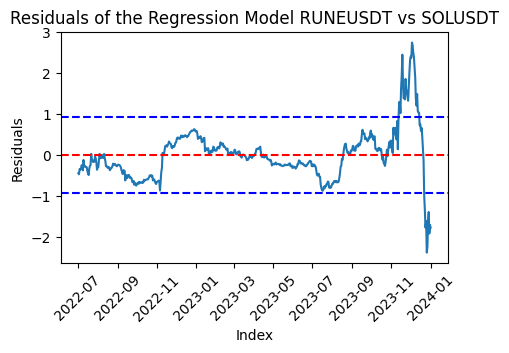

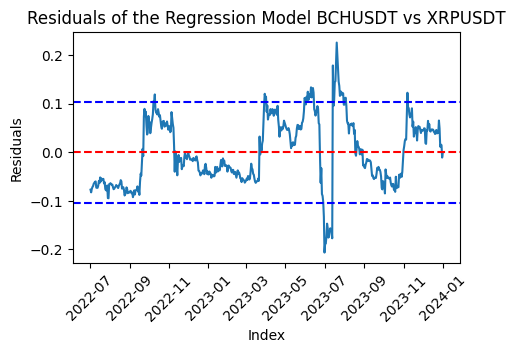

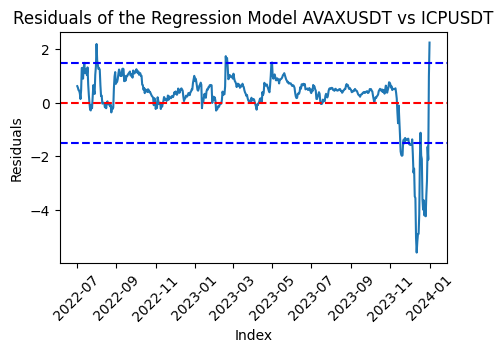

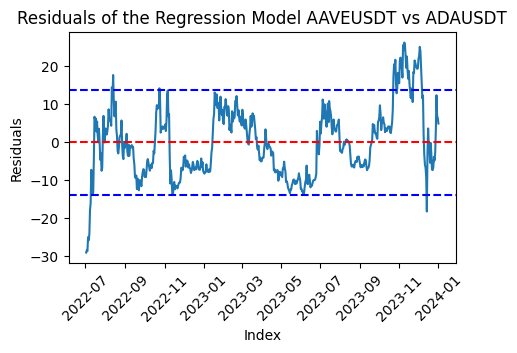

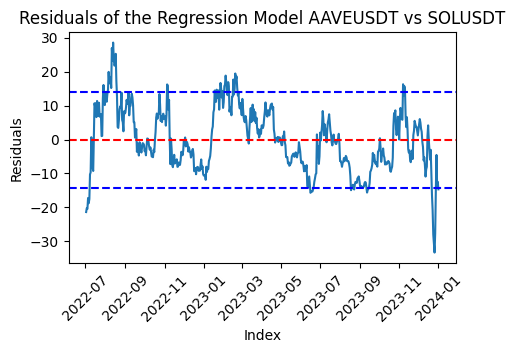

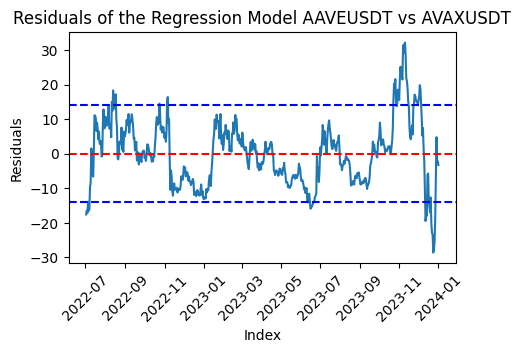

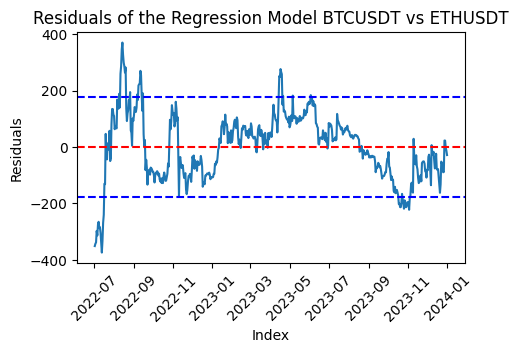

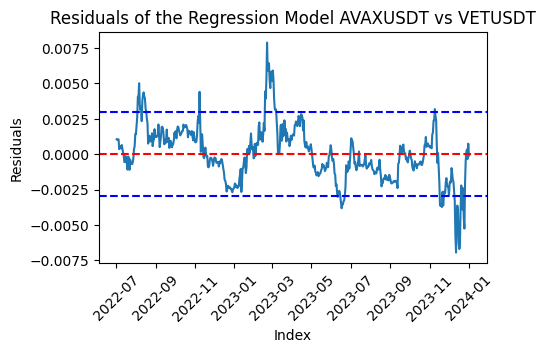

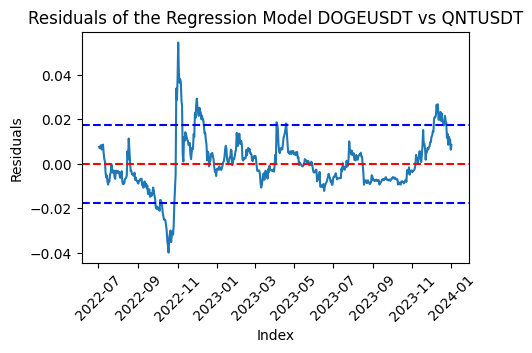

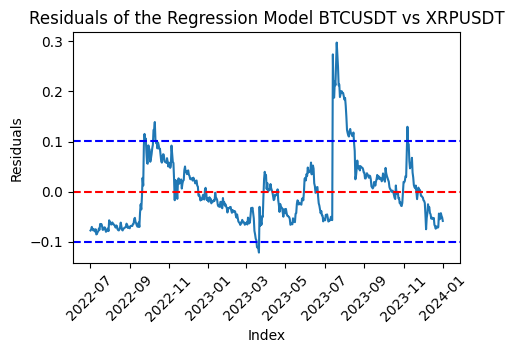

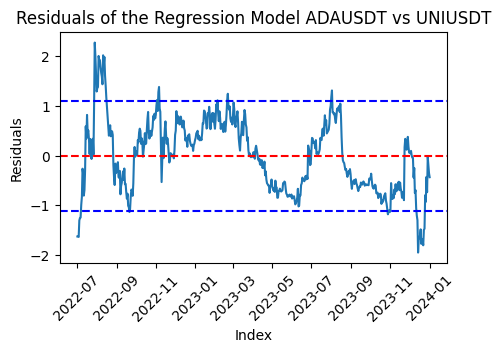

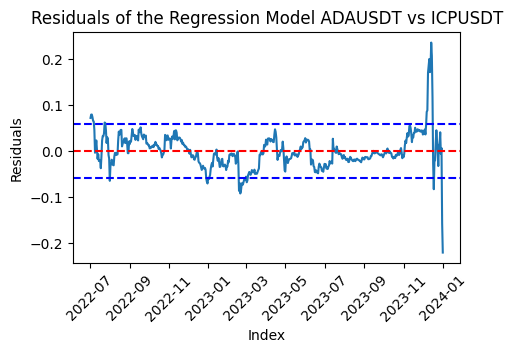

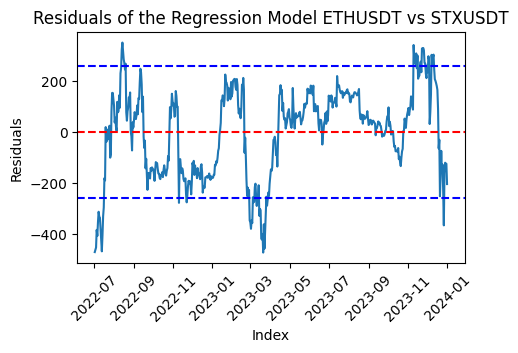

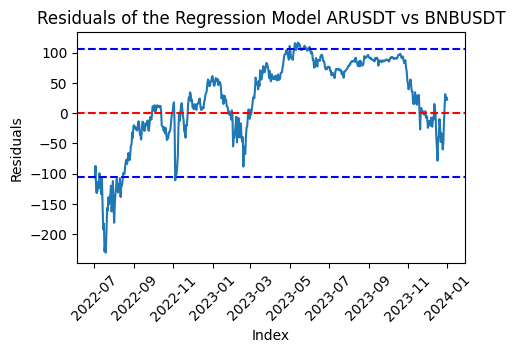

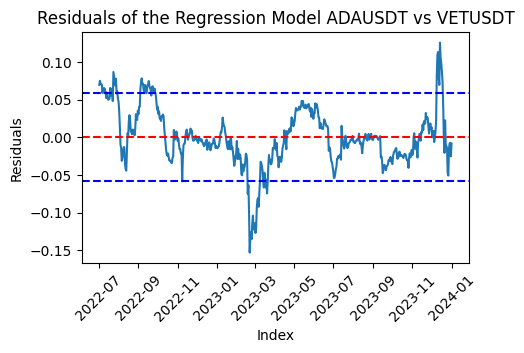

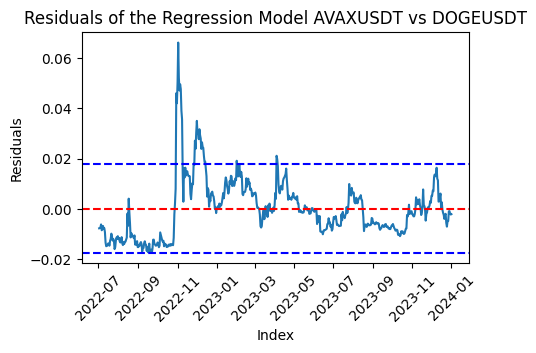

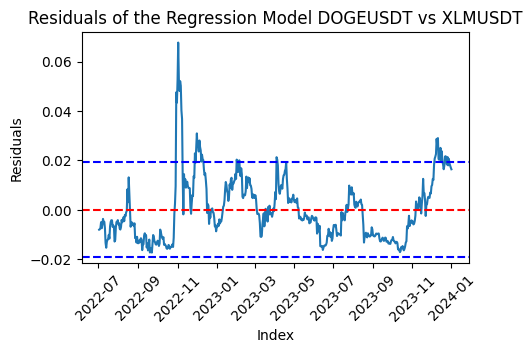

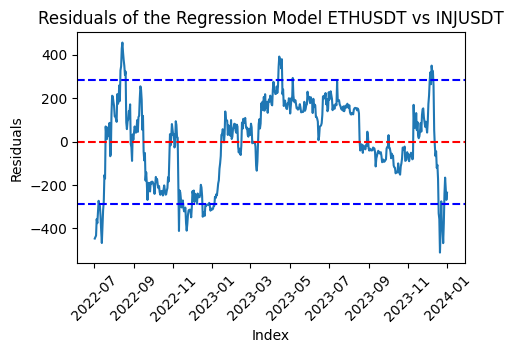

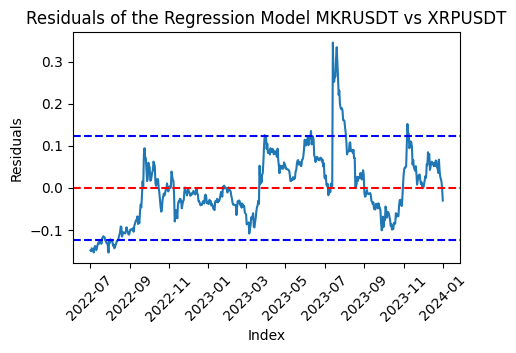

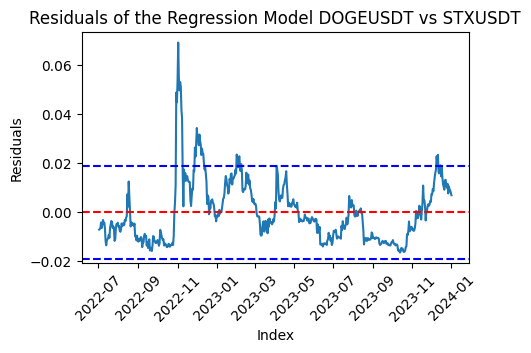

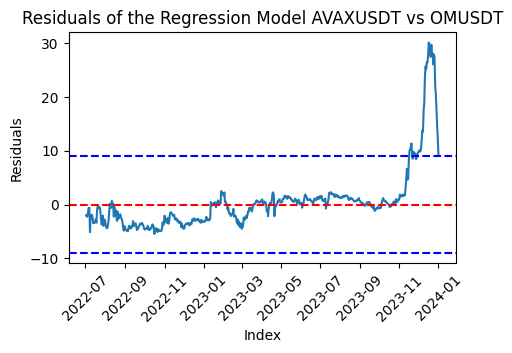

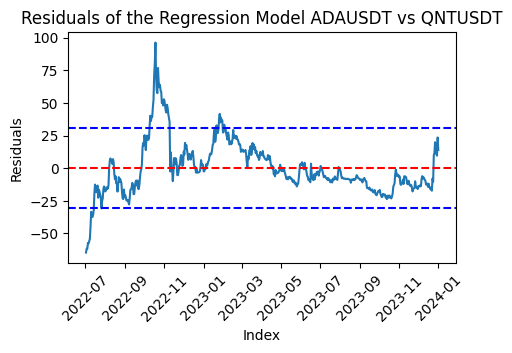

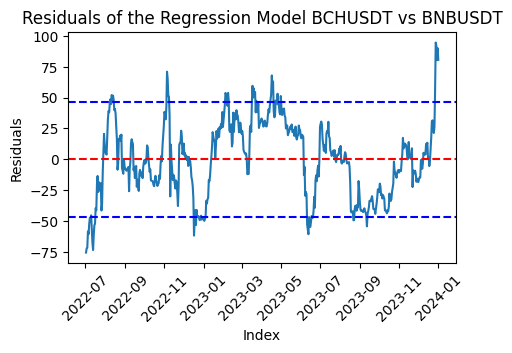

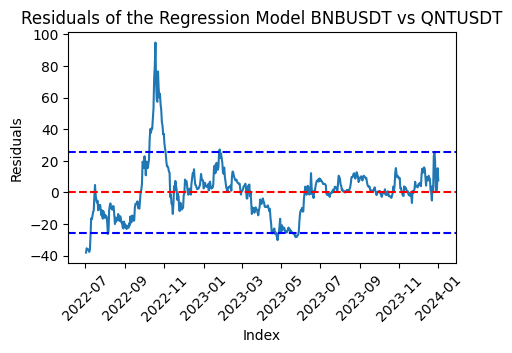

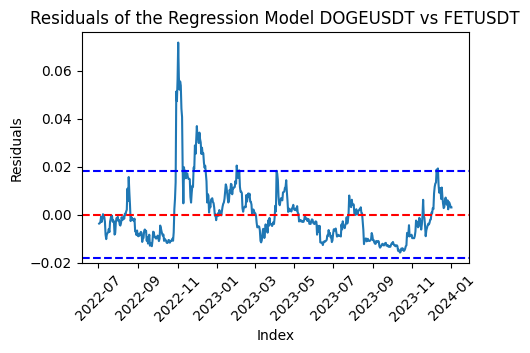

In [28]:
method_map = dict()
for pair1, pair2, score, method in pairs_to_check:
    method_map[(pair1, pair2)] = method
    visualise_residuals(df, pair1, pair2, method)

Pairs that will be backtested:
- ETHUSDT vs BTCUSDT
- AAVEUSDT vs SOLUSDT
- AAVEUSDT vs AVAXUSDT
- VETUSDT vs AVAXUSDT
- ETHUSDT vs STXUSDT

### Backtesting

#### Imports

In [63]:
import sys
import os

# Add the project root directory to sys.path
project_root = os.path.abspath("..")  # Move up one level from `analysis`
sys.path.append(project_root)

import importlib
from src.backtest import data_utils
from src.backtest import backtester

importlib.reload(data_utils)  # Reload the module
importlib.reload(backtester)  # Reload the module
from src.backtest.backtester import (
    PairsWithConstantStrategy,
    BacktestParameters,
    Backtest,
    BuyAndHoldStrategy,
)

#### Initialising Backtest Class

In [82]:
backtest_params = BacktestParameters(
    initial_capital=100000,
    trading_fee=0.001,
    slippage=0.001,
    interest_rate=0.05,
    risk_free_rate=0.05,
    position_size=1,
    stop_loss=0.1,
)
bt = Backtest(backtest_params)

#### Benchmarks
Buy and Hold BTCUSDT

BTCUSDT hold:
SL Triggered: 2024-01-22 23:59:59.999000

Backtest Summary
──────────────────────────────────────────────────
Initial Portfolio Value : $100,000.00
Final Portfolio Value   : $140,981.37
Total Return            : 41.24%
Annualized Return       : 58.95%
Sharpe Ratio            : 1.04
Maximum Drawdown        : -26.15%
Win Rate                : 0.0%
# of Closed Positions   : 1
# of Open Positions     : 1
──────────────────────────────────────────────────


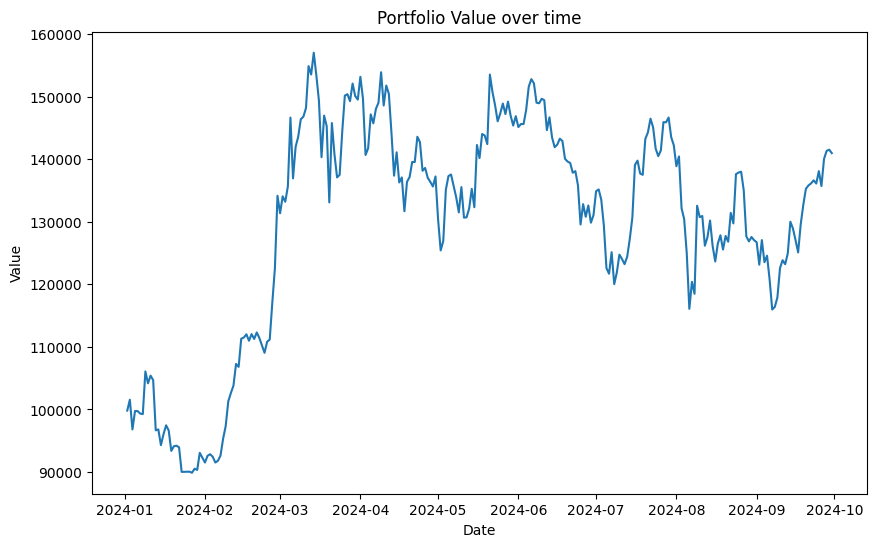

ETHUSDT hold:

Backtest Summary
──────────────────────────────────────────────────
Initial Portfolio Value : $100,000.00
Final Portfolio Value   : $112,781.67
Total Return            : 12.99%
Annualized Return       : 17.81%
Sharpe Ratio            : 0.50
Maximum Drawdown        : -45.26%
Win Rate                : No Closed Positions
# of Closed Positions   : 0
# of Open Positions     : 1
──────────────────────────────────────────────────


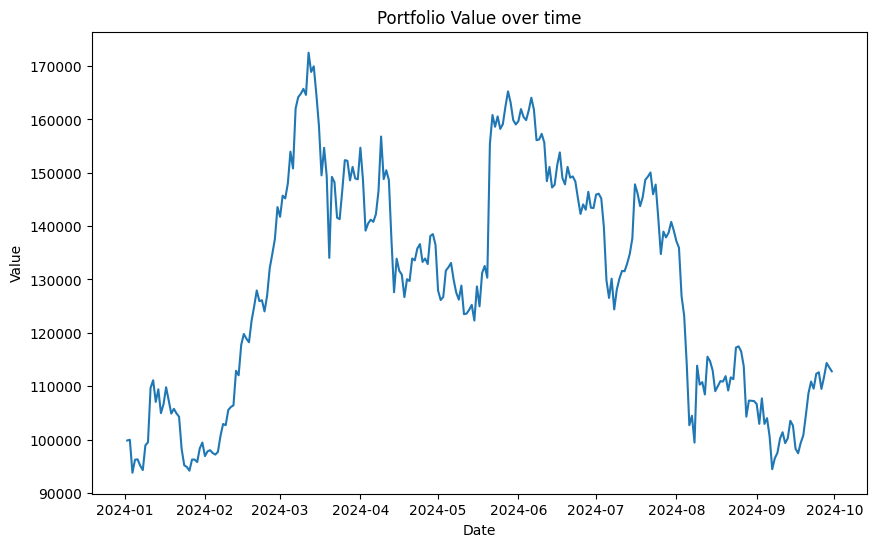

In [83]:
btc_strat = BuyAndHoldStrategy("BTCUSDT")
eth_strat = BuyAndHoldStrategy("ETHUSDT")

print("BTCUSDT hold:")
bt.run_backtest(df, "2024-01-01", "2024-09-30", btc_strat)
print("ETHUSDT hold:")
bt.run_backtest(df, "2024-01-01", "2024-09-30", eth_strat)

Backtesting pairs strategies

In [84]:
pairs_to_test = [
    ("BTCUSDT", "ETHUSDT"),
    ("AAVEUSDT", "SOLUSDT"),
    ("AAVEUSDT", "AVAXUSDT"),
    ("AVAXUSDT", "VETUSDT"),
    ("ETHUSDT", "STXUSDT"),
]

strategies = []
for pair1, pair2 in pairs_to_test:
    method = method_map[(pair1, pair2)]
    ticker1, ticker2, const, hedge_ratio, std = get_strategy_parameters(
        df, pair1, pair2, method
    )
    strategies.append(
        (
            ticker1,
            ticker2,
            PairsWithConstantStrategy(
                ticker1, ticker2, std, 1.5, 0.5, 1.5, 0.5, const, hedge_ratio
            ),
        )
    )

ETHUSDT vs BTCUSDT

Backtest Summary
──────────────────────────────────────────────────
Initial Portfolio Value : $100,000.00
Final Portfolio Value   : $116,733.87
Total Return            : 16.72%
Annualized Return       : 23.05%
Sharpe Ratio            : 0.94
Maximum Drawdown        : -9.35%
Win Rate                : 100.0%
# of Closed Positions   : 5
# of Open Positions     : 1
──────────────────────────────────────────────────


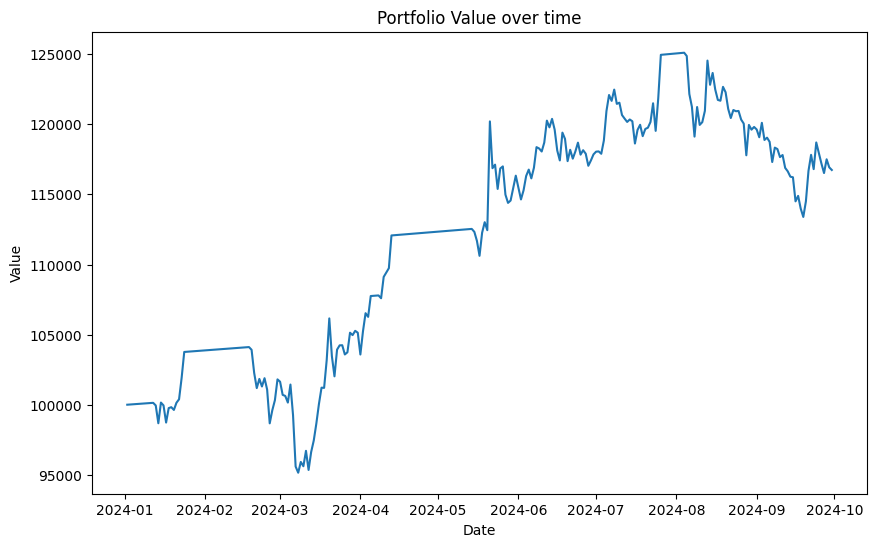

AAVEUSDT vs SOLUSDT
SL Triggered: 2024-01-31 23:59:59.999000
SL Triggered: 2024-03-16 23:59:59.999000

Backtest Summary
──────────────────────────────────────────────────
Initial Portfolio Value : $100,000.00
Final Portfolio Value   : $108,921.59
Total Return            : 8.91%
Annualized Return       : 12.13%
Sharpe Ratio            : 0.36
Maximum Drawdown        : -27.96%
Win Rate                : 50.0%
# of Closed Positions   : 4
# of Open Positions     : 0
──────────────────────────────────────────────────


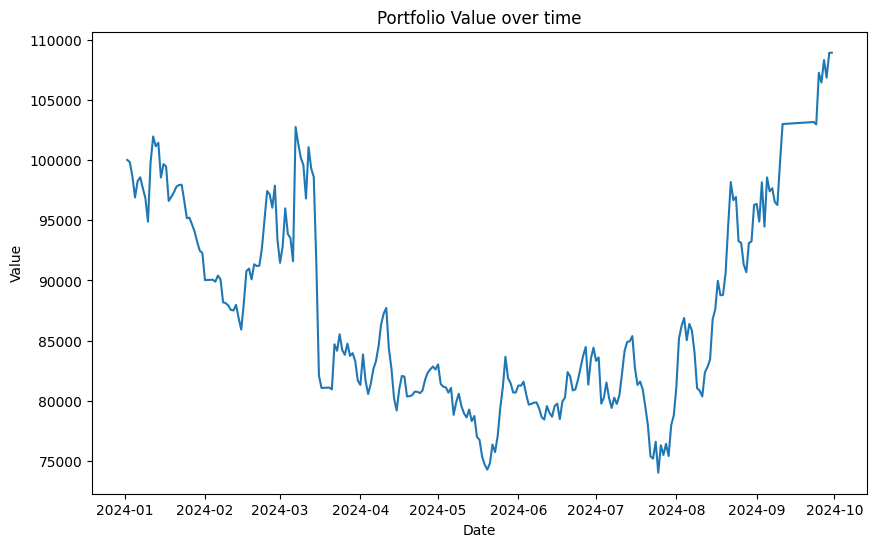

AAVEUSDT vs AVAXUSDT
SL Triggered: 2024-08-19 23:59:59.999000
SL Triggered: 2024-09-23 23:59:59.999000

Backtest Summary
──────────────────────────────────────────────────
Initial Portfolio Value : $100,000.00
Final Portfolio Value   : $141,087.04
Total Return            : 41.07%
Annualized Return       : 58.68%
Sharpe Ratio            : 1.32
Maximum Drawdown        : -22.70%
Win Rate                : 71.4%
# of Closed Positions   : 7
# of Open Positions     : 1
──────────────────────────────────────────────────


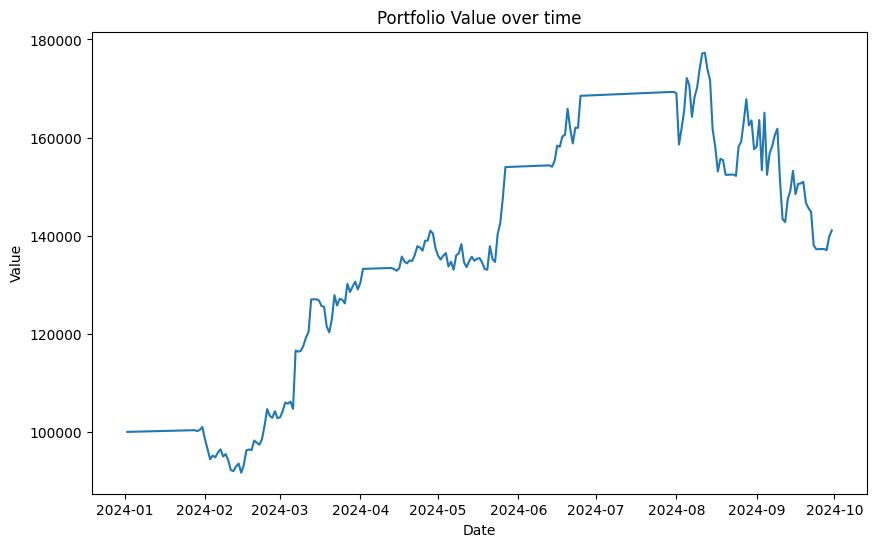

VETUSDT vs AVAXUSDT

Backtest Summary
──────────────────────────────────────────────────
Initial Portfolio Value : $100,000.00
Final Portfolio Value   : $154,816.04
Total Return            : 54.80%
Annualized Return       : 79.74%
Sharpe Ratio            : 2.18
Maximum Drawdown        : -9.83%
Win Rate                : 100.0%
# of Closed Positions   : 6
# of Open Positions     : 1
──────────────────────────────────────────────────


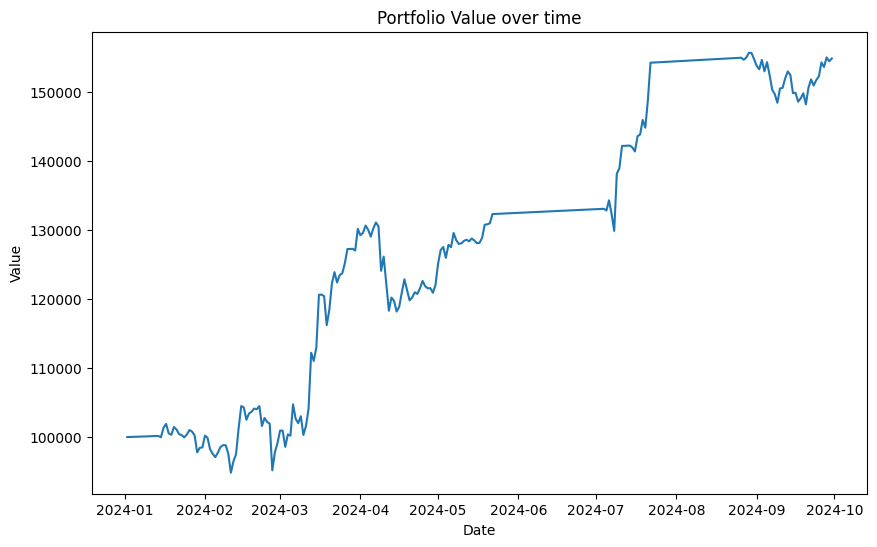

ETHUSDT vs STXUSDT
SL Triggered: 2024-03-23 23:59:59.999000

Backtest Summary
──────────────────────────────────────────────────
Initial Portfolio Value : $100,000.00
Final Portfolio Value   : $137,327.00
Total Return            : 37.31%
Annualized Return       : 53.03%
Sharpe Ratio            : 1.45
Maximum Drawdown        : -13.52%
Win Rate                : 85.7%
# of Closed Positions   : 7
# of Open Positions     : 1
──────────────────────────────────────────────────


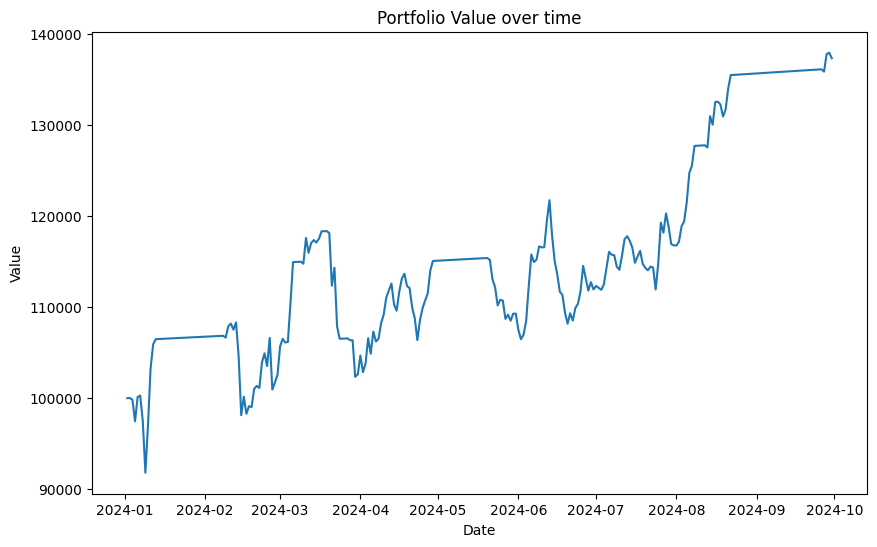

In [85]:
for first_pair, second_pair, strat in strategies:
    print(f"{first_pair} vs {second_pair}")
    bt.run_backtest(df, "2024-01-01", "2024-09-30", strat)